In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.metrics import precision_recall_curve

In [2]:
df = pd.read_csv("Telco_Customer_Churn.csv")
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan), errors="coerce")
df.dropna(inplace=True)
df["Churn_Flag"] = df["Churn"].map({"Yes": 1, "No": 0})

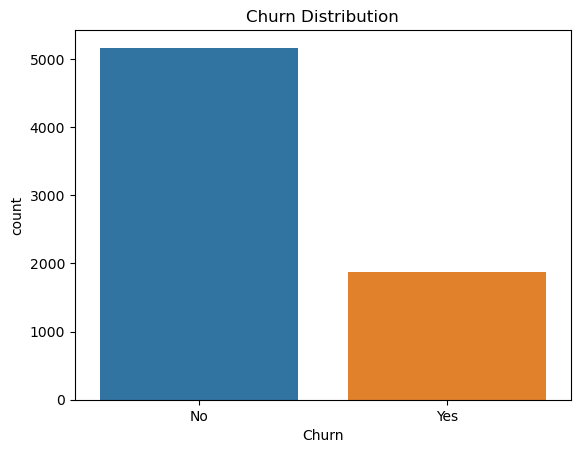

In [4]:
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

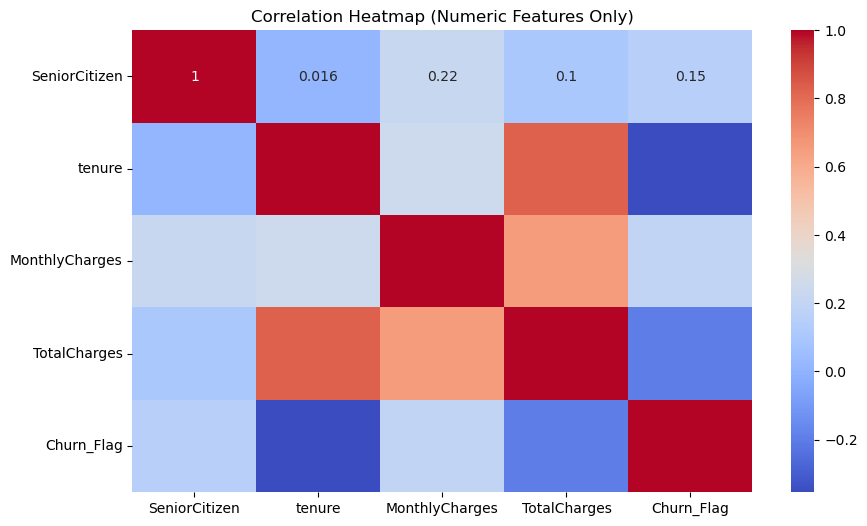

In [5]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

In [6]:
id_cols = ["customerID"]
target = "Churn_Flag"
feature_cols = [c for c in df.columns if c not in id_cols + [target, "Churn"]]
X = df[feature_cols]
y = df[target]
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler(with_mean=False))])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [8]:
logreg = Pipeline(steps=[("prep", preprocess), ("clf", LogisticRegression(max_iter=2000))])
logreg.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf', LogisticRegression(max_iter=2000))])

In [9]:
rf = Pipeline(steps=[("prep", preprocess), ("clf", RandomForestClassifier(n_estimators=400, random_state=42))])
rf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=400, random_state=42))])


Model: Logistic Regression
Accuracy: 0.8061611374407583
Precision: 0.6570247933884298
Recall: 0.5668449197860963
F1: 0.6086124401913875
ROC-AUC: 0.8378316641522505
Confusion Matrix:
 [[1383  166]
 [ 243  318]]


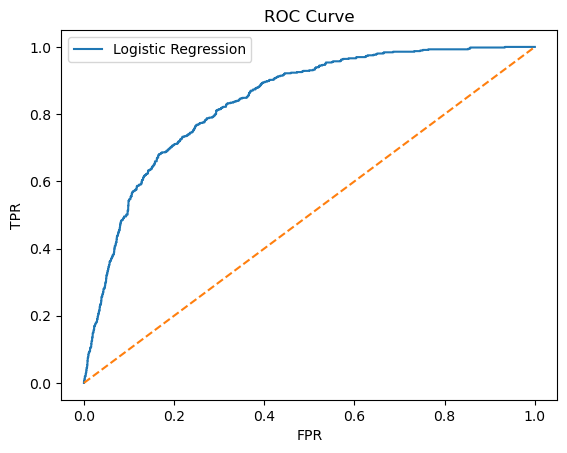


Model: Random Forest
Accuracy: 0.7767772511848341
Precision: 0.6041666666666666
Recall: 0.46524064171123
F1: 0.525679758308157
ROC-AUC: 0.8122939415803883
Confusion Matrix:
 [[1378  171]
 [ 300  261]]


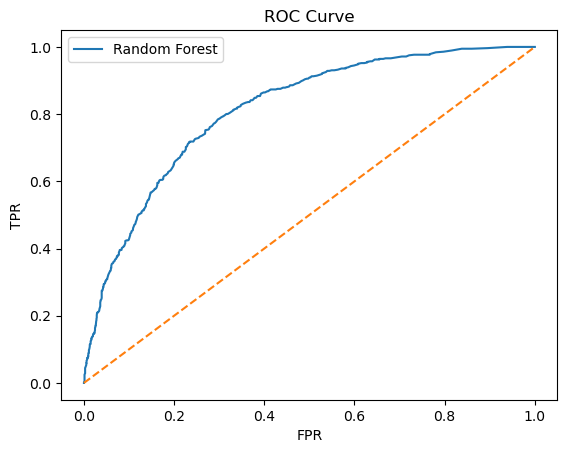

In [10]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
    plt.legend()
    plt.show()

evaluate(logreg, X_test, y_test, "Logistic Regression")
evaluate(rf, X_test, y_test, "Random Forest")

Business Takeaway :

Logistic Regression → Better at catching churners and balancing false alarms.

Random Forest → More complex but didn’t outperform Logistic Regression in this dataset.

So, for churn prediction project, Logistic Regression should be the primary model for deployment.

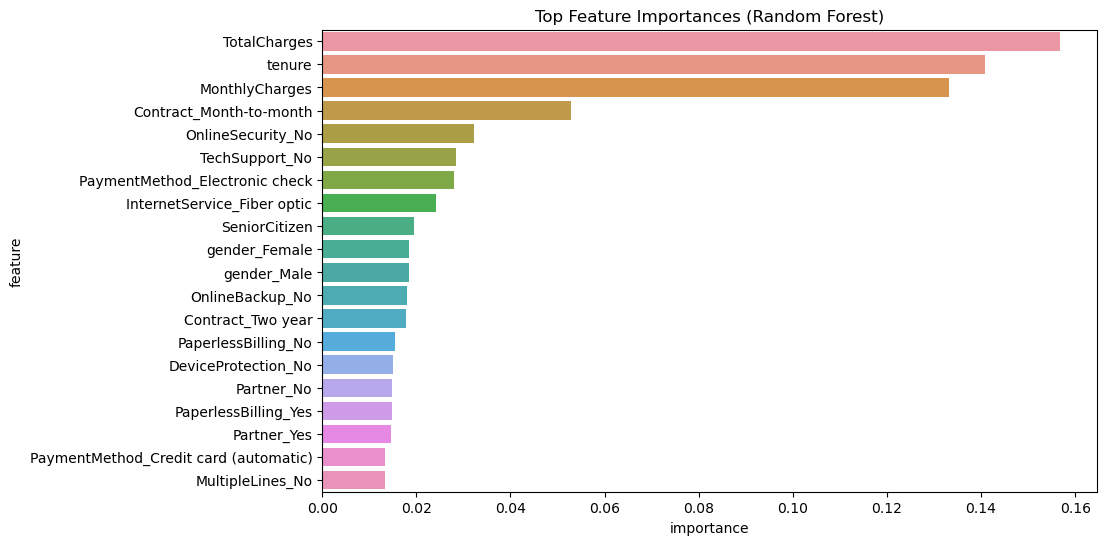

In [11]:
ohe = preprocess.named_transformers_["cat"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
encoded_feature_names = numeric_cols + cat_names

if hasattr(rf.named_steps["clf"], "feature_importances_"):
    importances = rf.named_steps["clf"].feature_importances_
    feat_imp = pd.DataFrame({"feature": encoded_feature_names, "importance": importances})
    feat_imp = feat_imp.sort_values("importance", ascending=False).head(20)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=feat_imp)
    plt.title("Top Feature Importances (Random Forest)")
    plt.show()

In [12]:
rf_probs = rf.predict_proba(X_test)[:,1]
preds_df = pd.DataFrame({
    "CustomerID": df.loc[X_test.index, "customerID"],
    "Actual": y_test,
    "Predicted": rf.predict(X_test),
    "Churn_Probability": rf_probs
}).sort_values("Churn_Probability", ascending=False)

high_risk = preds_df.head(int(0.15*len(preds_df)))
high_risk.head(10)

,CustomerID,Actual,Predicted,Churn_Probability
1731,8375-DKEBR,1,1,0.9975
2194,2514-GINMM,1,1,0.9925
2927,5542-TBBWB,0,1,0.9925
1739,9804-ICWBG,1,1,0.9925
684,8040-MNRTF,0,1,0.9925
6368,2720-WGKHP,1,1,0.9900
6488,0488-GSLFR,1,1,0.9900
6764,7660-HDPJV,1,1,0.9875
3682,3716-BDVDB,1,1,0.9875
809,1820-TQVEV,1,1,0.9850


Business Recommendations :

Key Churn Drivers (from feature importance & Exploratory Data Analysis)

Contract Type
Customers on month-to-month contracts churn significantly more compared to those on 1-year or 2-year contracts.

Tenure (Customer Lifetime)
Customers with low tenure (new users) are at higher risk of churn. Loyalty tends to increase over time.

Payment Method
Customers using electronic check as payment are more likely to churn than those using credit card, bank transfer, or automatic payment methods.

Monthly Charges
Higher charges (especially without bundled services) are linked to higher churn rates.

Recommended Retention Strategies :

Improve Contract Retention

Encourage customers to switch from month-to-month to annual contracts with discounts or free add-ons.

Offer flexible upgrade paths for longer commitments.

Target New Customers (Low Tenure)

Provide onboarding programs and regular engagement check-ins in the first 3 months.

Offer loyalty points or early incentives to reduce early churn.

Payment Method Optimization

Incentivize switching from electronic check to auto-pay/credit card by offering small discounts.

Educate customers about security and convenience of digital payments.

Pricing & Value Communication

For high monthly charges, bundle additional services (e.g., internet + TV + phone) to increase perceived value.

Offer personalized discounts to at-risk high-charge customers.

Proactive Customer Support

Use churn predictions to flag high-risk customers.

Reach out with personalized retention offers, faster support, and follow-up calls.

Outcome Expected: Lower churn rate, improved customer satisfaction, and increased customer lifetime value (CLV).

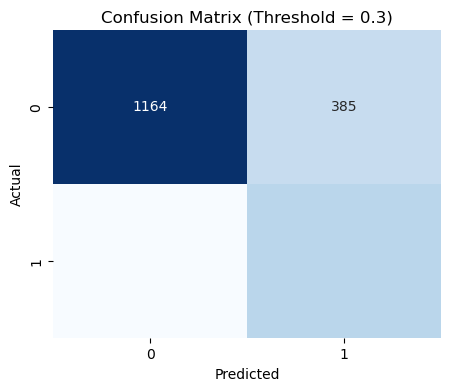

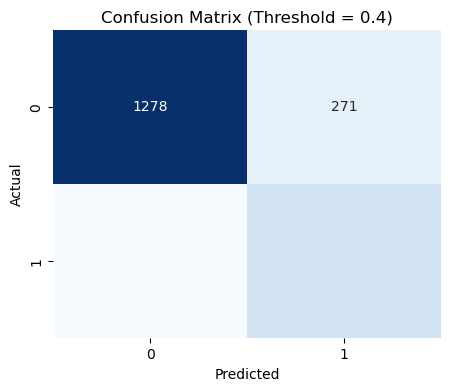

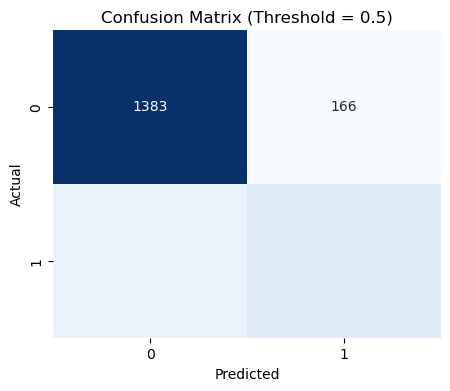

In [13]:
def plot_conf_matrix(y_true, y_pred, threshold):
    cm = confusion_matrix(y_true, (y_pred >= threshold).astype(int))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
y_pred_proba = logreg.predict_proba(X_test)[:,1]
for t in [0.3, 0.4, 0.5]:
    plot_conf_matrix(y_test, y_pred_proba, t)

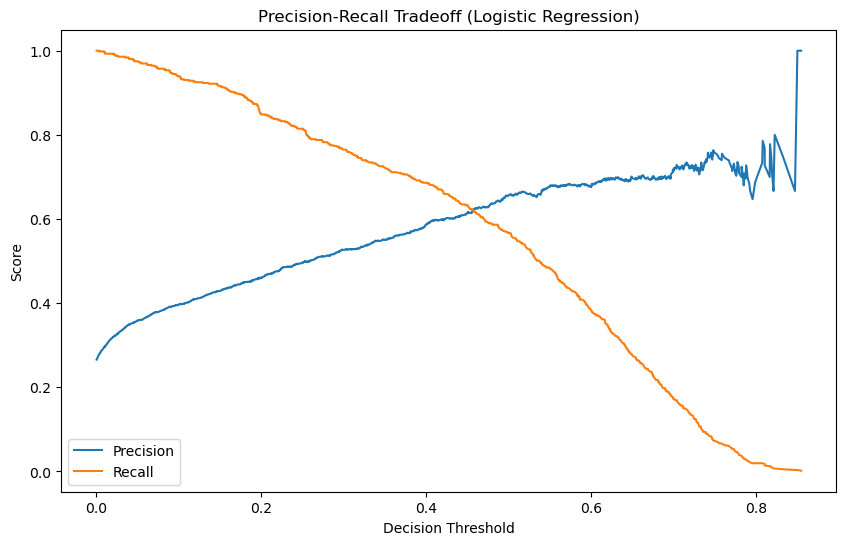

In [14]:
y_proba = logreg.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff (Logistic Regression)")
plt.legend()
plt.show()

In [15]:
def evaluate_at_threshold(model, X, y, threshold):
    probs = model.predict_proba(X)[:,1]
    preds = (probs >= threshold).astype(int)
    
    print(f"\n--- Threshold = {threshold:.2f} ---")
    print("Accuracy:", accuracy_score(y, preds))
    print("Precision:", precision_score(y, preds))
    print("Recall:", recall_score(y, preds))
    print("F1:", f1_score(y, preds))
    print("Confusion Matrix:\n", confusion_matrix(y, preds))

evaluate_at_threshold(logreg, X_test, y_test, 0.50)  # default
evaluate_at_threshold(logreg, X_test, y_test, 0.40)
evaluate_at_threshold(logreg, X_test, y_test, 0.30)


--- Threshold = 0.50 ---
Accuracy: 0.8061611374407583
Precision: 0.6570247933884298
Recall: 0.5668449197860963
F1: 0.6086124401913875
Confusion Matrix:
 [[1383  166]
 [ 243  318]]

--- Threshold = 0.40 ---
Accuracy: 0.7881516587677725
Precision: 0.586890243902439
Recall: 0.6862745098039216
F1: 0.6327033689400164
Confusion Matrix:
 [[1278  271]
 [ 176  385]]

--- Threshold = 0.30 ---
Accuracy: 0.7549763033175355
Precision: 0.527027027027027
Recall: 0.7647058823529411
F1: 0.6239999999999999
Confusion Matrix:
 [[1164  385]
 [ 132  429]]


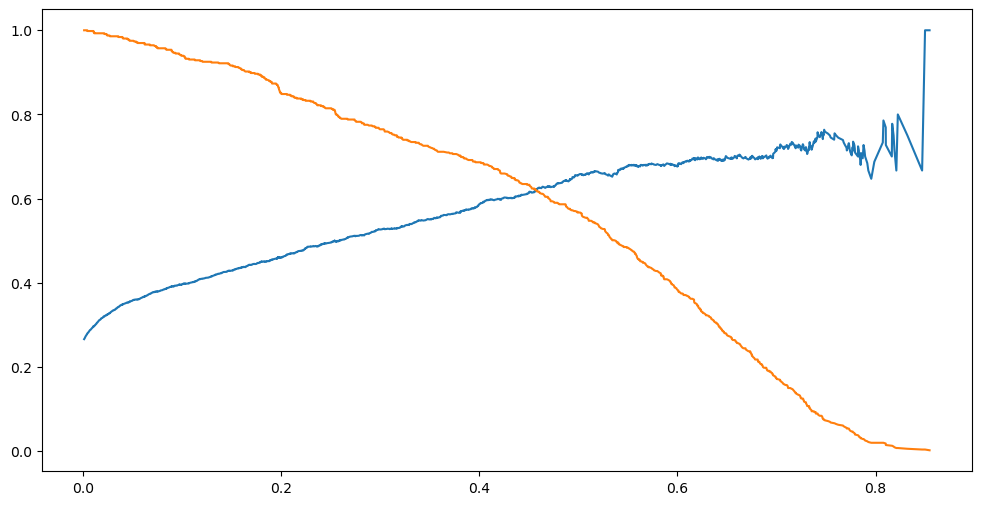

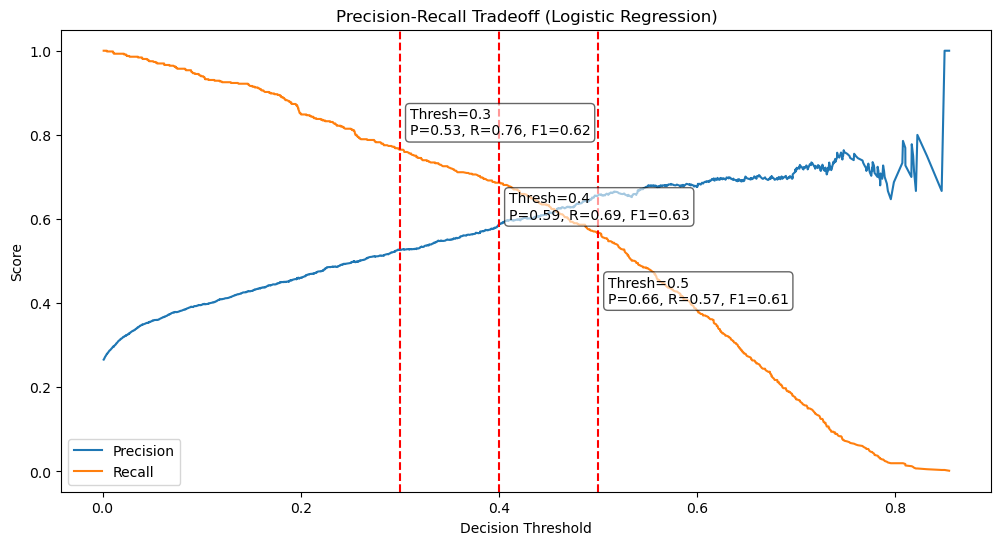

In [16]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(12,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")

def annotate_threshold(threshold, y_pos):
    y_pred = (y_pred_proba >= threshold).astype(int)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    plt.axvline(x=threshold, color="red", linestyle="--")
    
    plt.text(threshold+0.01, y_pos, 
             f"Thresh={threshold}\nP={p:.2f}, R={r:.2f}, F1={f1:.2f}", 
             rotation=0, color="black", 
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

plt.figure(figsize=(12,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")

annotate_threshold(0.3, 0.8)
annotate_threshold(0.4, 0.6)
annotate_threshold(0.5, 0.4)

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff (Logistic Regression)")
plt.legend()
plt.show()

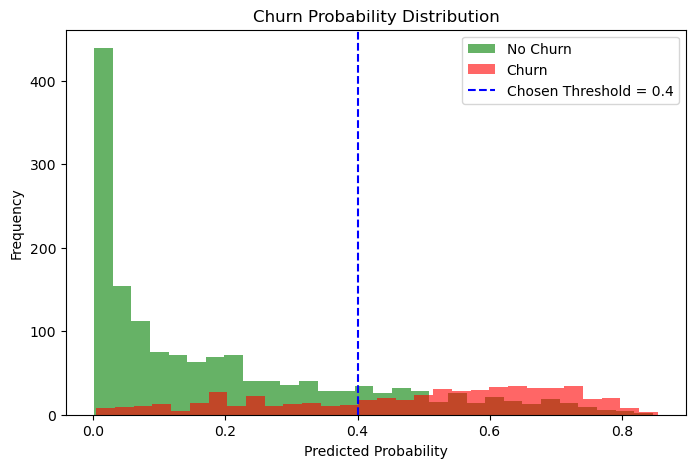

In [17]:
plt.figure(figsize=(8,5))
plt.hist(y_proba[y_test==0], bins=30, alpha=0.6, label="No Churn", color="green")
plt.hist(y_proba[y_test==1], bins=30, alpha=0.6, label="Churn", color="red")
plt.axvline(0.4, color="blue", linestyle="--", label="Chosen Threshold = 0.4")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Churn Probability Distribution")
plt.legend()
plt.show()

In [18]:
logreg.named_steps.keys()

dict_keys(['prep', 'clf'])

<Figure size 800x600 with 0 Axes>

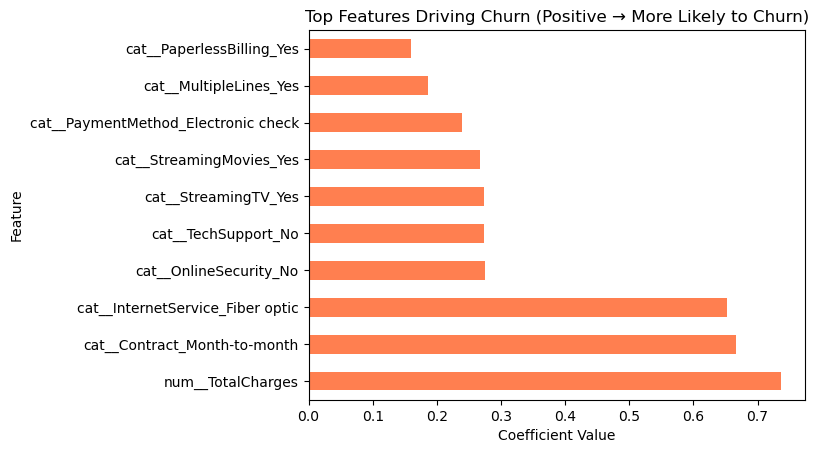

In [19]:
logreg_model = logreg.named_steps['clf']

feature_names = logreg.named_steps['prep'].get_feature_names_out()

coeffs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logreg_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8,6))
coeffs.head(10).set_index("Feature").plot(kind="barh", legend=False, color="coral")
plt.title("Top Features Driving Churn (Positive → More Likely to Churn)")
plt.xlabel("Coefficient Value")
plt.show()

Outcomes from Threshold Analysis :
At Different Thresholds

Threshold = 0.50 (Default)

Accuracy: 80.6%

Precision: 65.7%

Recall: 56.7%

Balanced, but recall is a bit low → some churners are missed.

Threshold = 0.40

Accuracy: 78.8%

Precision: 58.7%

Recall: 68.6%

More customers at risk of churn are detected, but some false alarms increase.

Threshold = 0.30

Accuracy: 75.5%

Precision: 52.7%

Recall: 76.5%

Highest recall → most churners caught, but precision drops (more false positives).

Interpretation for the Business :

High Recall (Thresh=0.30) → Best if the business wants to catch as many churners as possible, even if it means reaching out to some customers who wouldn’t have left.
Use case: Retention campaigns, loyalty offers, proactive customer support.

Balanced (Thresh=0.40–0.50) → Keeps a balance between catching churners and avoiding unnecessary costs from targeting too many false positives.
Use case: When the budget for retention offers is limited and needs focus.

High Precision (Thresh > 0.50) → Fewer false positives, but more churners may be missed.
Use case: When each retention action is expensive (e.g., heavy discounts).

Recommendation :

Use Threshold = 0.40 as the operational sweet spot:

Captures most at-risk customers (higher recall than 0.50).

Keeps precision reasonable so retention actions aren’t wasted.

Build a tiered retention strategy:

Customers flagged at 0.30–0.40 → send low-cost retention offers (emails, loyalty points).

Customers flagged at ≥0.40 → give high-value interventions (discounts, personal calls).

In [20]:
churn_predictions = pd.DataFrame({
    'customerID': X_test.index.astype(str),
    'Churn_Probability': y_pred_proba,
    'Churn': np.where(y_test.values == 1, "Yes", "No")
})

In [21]:
df = df.drop(columns=['Customer ID'], errors='ignore')   # remove duplicate if exists
df.rename(columns={'customerID': 'Customer ID'}, inplace=True)

churn_predictions.rename(columns={'customerID': 'Customer ID'}, inplace=True)

churn_predictions.to_csv("Churn_Predictions.csv", index=False)